### Introducción:

Esta notebook presenta el análisis y desarrollo de modelos predictivos para las ventas mensuales de la empresa de software 1C Company en Rusia, en el marco de una competencia de Kaggle. El objetivo principal es predecir las ventas del próximo mes utilizando datos históricos de ventas diarias, donde se busca minimizar el RMSE. Para esto se realizó un proceso de selección y preparación de datos (feature engineering y data preprocessing), construcción de modelos y evaluación de su rendimiento.


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/TP2CienciaDeDatos/item_categories.csv'
item_categories = pd.read_csv(path)

path = '/content/gdrive/MyDrive/TP2CienciaDeDatos/items.csv'
items = pd.read_csv(path)

path = '/content/gdrive/MyDrive/TP2CienciaDeDatos/sales_train.csv'
sales_train = pd.read_csv(path) #pd.read_csv(path, encoding='latin-1')

path = '/content/gdrive/MyDrive/TP2CienciaDeDatos/shops.csv'
shops = pd.read_csv(path)

path = '/content/gdrive/MyDrive/TP2CienciaDeDatos/test.csv'
test = pd.read_csv(path)

In [ ]:
item_categories = pd.read_csv("/content/gdrive/MyDrive/TP 2/item_categories.csv")
items = pd.read_csv("/content/gdrive/MyDrive/TP 2/items.csv")
sales_train = pd.read_csv("/content/gdrive/MyDrive/TP 2/sales_train.csv")
shops = pd.read_csv("/content/gdrive/MyDrive/TP 2/shops.csv")
test = pd.read_csv("/content/gdrive/MyDrive/TP 2/test.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
item_categories.head(),items.head(),sales_train.head(),shops.head(),test.head()

(        item_category_name  item_category_id
 0  PC - Гарнитуры/Наушники                 0
 1         Аксессуары - PS2                 1
 2         Аксессуары - PS3                 2
 3         Аксессуары - PS4                 3
 4         Аксессуары - PSP                 4,
                                            item_name  item_id  \
 0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
 1  !ABBYY FineReader 12 Professional Edition Full...        1   
 2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
 3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
 4        ***КОРОБКА (СТЕКЛО)                       D        4   
 
    item_category_id  
 0                40  
 1                76  
 2                40  
 3                40  
 4                40  ,
          date  date_block_num  shop_id  item_id  item_price  item_cnt_day
 0  02.01.2013               0       59    22154      999.00           1.0
 1  03.01.2013               0      

In [ ]:
(len(item_categories),item_categories.size),  (len(items),items.size),  (len(sales_train),sales_train.size),  (len(shops),shops.size)

((84, 168), (22170, 66510), (2935849, 17615094), (60, 120))

In [ ]:
# Joineamos todos los dfs provistos por Kaggle con sus claves primarias comunes para aprovechar todas las columnas:

sales_items = pd.merge(sales_train, items, on='item_id', how='left')

sales_items_categories = pd.merge(sales_items, item_categories, on='item_category_id', how='left')

complete_sales_data = pd.merge(sales_items_categories, shops, on='shop_id', how='left')


(len(complete_sales_data),complete_sales_data.size)

(2935849, 32294339)

In [ ]:
# Creo feature de ganancias
complete_sales_data['revenue'] = complete_sales_data['item_cnt_day'] * complete_sales_data['item_price']

In [ ]:
# Cantidad de duplicados
complete_sales_data.duplicated().sum()

6

In [ ]:
# Eliminamos duplicados
complete_sales_data.drop_duplicates(inplace=True)

  Traduciendo una muestra del dataframe vimos que se podían extraer la información de ciudad de la columna shop_name, y de tipo y subtipo de la columna item_category_name:


In [ ]:
# Por los comentarios de la competencia podemos extraer la siguiente información

complete_sales_data['city'] = complete_sales_data['shop_name'].str.split(' ').map(lambda x: x[0])

complete_sales_data['type'] = complete_sales_data['item_category_name'].str.split('-').map(lambda x: x[0].strip())

# si no tiene subtipo, se asigna el tipo
complete_sales_data['subtype'] = complete_sales_data['item_category_name'].str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())


In [ ]:
complete_sales_data.describe(), complete_sales_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869525 entries, 0 to 1869524
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      float64
 2   shop_id             float64
 3   item_id             float64
 4   item_price          float64
 5   item_cnt_day        float64
 6   item_name           object 
 7   item_category_id    float64
 8   item_category_name  object 
 9   shop_name           object 
dtypes: float64(6), object(4)
memory usage: 142.6+ MB


(       date_block_num       shop_id       item_id    item_price  item_cnt_day  \
 count    1.869524e+06  1.869524e+06  1.869524e+06  1.869524e+06  1.869524e+06   
 mean     8.530385e+00  3.293121e+01  1.014551e+04  7.719628e+02  1.225181e+00   
 std      5.396007e+00  1.630290e+01  6.327429e+03  1.453818e+03  1.781571e+00   
 min      0.000000e+00  0.000000e+00  1.000000e+00 -1.000000e+00 -2.200000e+01   
 25%      4.000000e+00  2.200000e+01  4.420000e+03  2.094200e+02  1.000000e+00   
 50%      9.000000e+00  3.100000e+01  9.053000e+03  3.990000e+02  1.000000e+00   
 75%      1.300000e+01  4.700000e+01  1.561500e+04  7.990000e+02  1.000000e+00   
 max      1.900000e+01  5.900000e+01  2.216900e+04  3.079800e+05  5.020000e+02   
 
        item_category_id  
 count      1.869524e+06  
 mean       3.963649e+01  
 std        1.643341e+01  
 min        0.000000e+00  
 25%        3.000000e+01  
 50%        4.000000e+01  
 75%        5.500000e+01  
 max        8.300000e+01  ,
 None)

# Análisis exploratorio

### Tendencia de ventas mensuales:

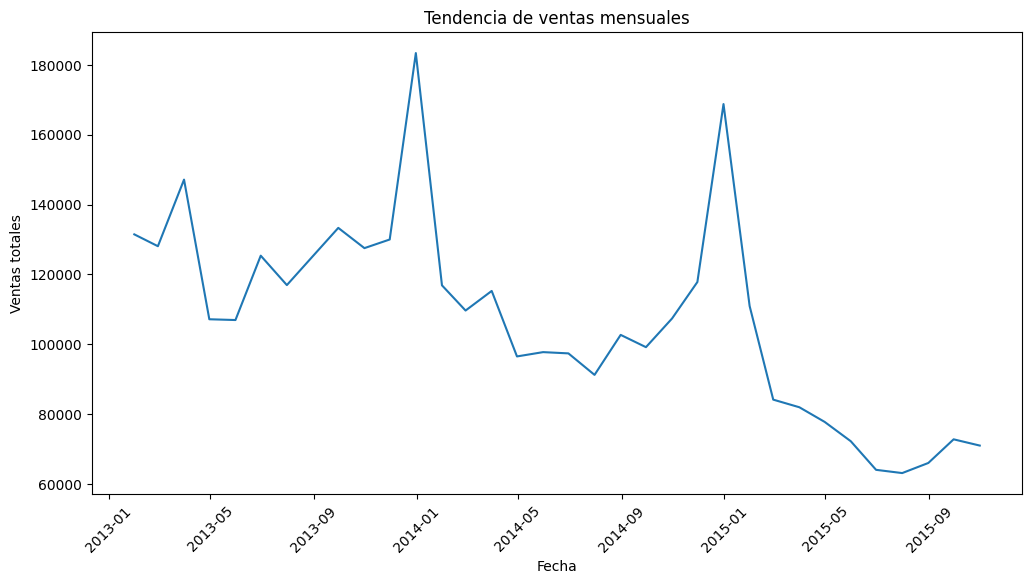

In [ ]:
# Convertir la columna 'date' a formato de fecha
complete_sales_data['date'] = pd.to_datetime(complete_sales_data['date'], format='%d.%m.%Y')


# line plot: Tendencia de ventas a lo largo del tiempo
plt.figure(figsize=(12, 6))
sales_trend = complete_sales_data.groupby(pd.Grouper(key='date', freq='M'))['item_cnt_day'].sum().reset_index()
sns.lineplot(x='date', y='item_cnt_day', data=sales_trend)
plt.xticks(rotation=45)
plt.xlabel('Fecha')
plt.ylabel('Ventas totales')
plt.title('Tendencia de ventas mensuales')
# Formatear las fechas en el eje x para mostrar solo los años
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.show()

- Se observa una estructura con estacionalidad anual.
- Se observa una tendencia general decreciente en las ventas totales desde 2013 hasta finales de 2015.
- Hay picos pronunciados de ventas a principios de 2014 y 2015, posiblemente relacionados con temporadas altas.
- La volatilidad de las ventas parece disminuir hacia el final del período.


### Categorías con más ventas a lo largo del tiempo:

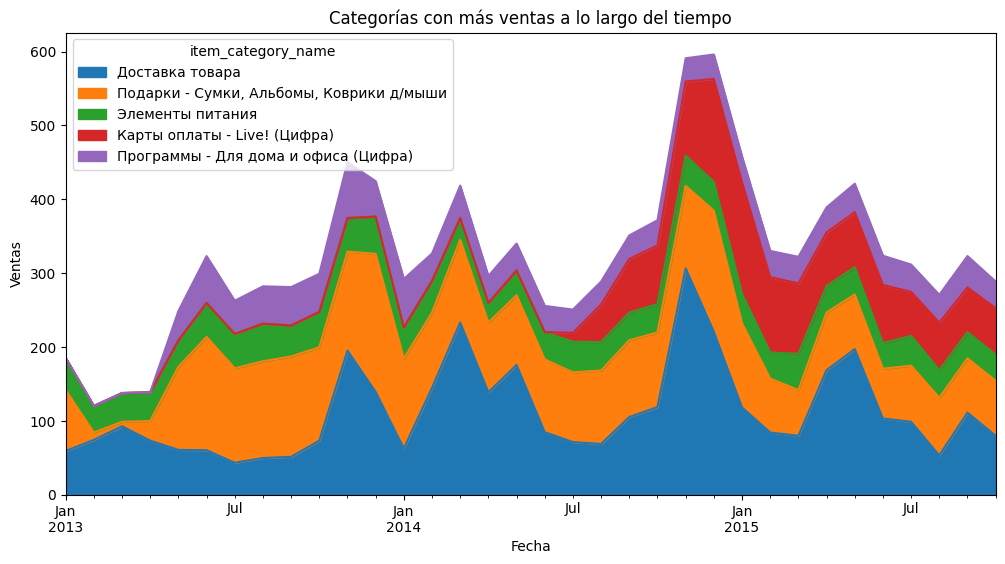

In [ ]:
import matplotlib.dates as mdates
import pandas as pd

sales_by_category = complete_sales_data[complete_sales_data['item_cnt_day'] >= 0]
sales_by_category = sales_by_category.groupby(['date', 'item_category_name'])['item_cnt_day'].median().reset_index()
sales_by_category['date'] = pd.to_datetime(sales_by_category['date'], format='%d.%m.%Y')
sales_by_category = sales_by_category.pivot_table(index='date', columns='item_category_name', values='item_cnt_day', fill_value=0)

category_totals = sales_by_category.sum().sort_values(ascending=False)

top_categories = category_totals.nlargest(5).index

new_data = sales_by_category[top_categories].copy()

new_data = new_data.resample('M').sum()

new_data = new_data.fillna(0)

fig, ax = plt.subplots(figsize=(12, 6))
new_data.plot(kind='area', stacked=True, ax=ax)


plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Categorías con más ventas a lo largo del tiempo')
plt.show()

- Se puede ver una desagregación de la cantidad de ventas mensuales por categorías más predominantes.
- Hay una preservación del comportamiento de estacionalidad clara a través de las categorías, con picos recurrentes a finales de cada año.
- La marcada estacionalidad en las ventas sugiere la implementación de modelos de series temporales que capturen estos patrones cíclicos para mejorar las predicciones.
- La fluctuación en la cantidad de artículos vendidos sugiere la importancia de segmentar las predicciones por tipo de producto para mejorar la precisión general.


### Categorías de más ganancias:

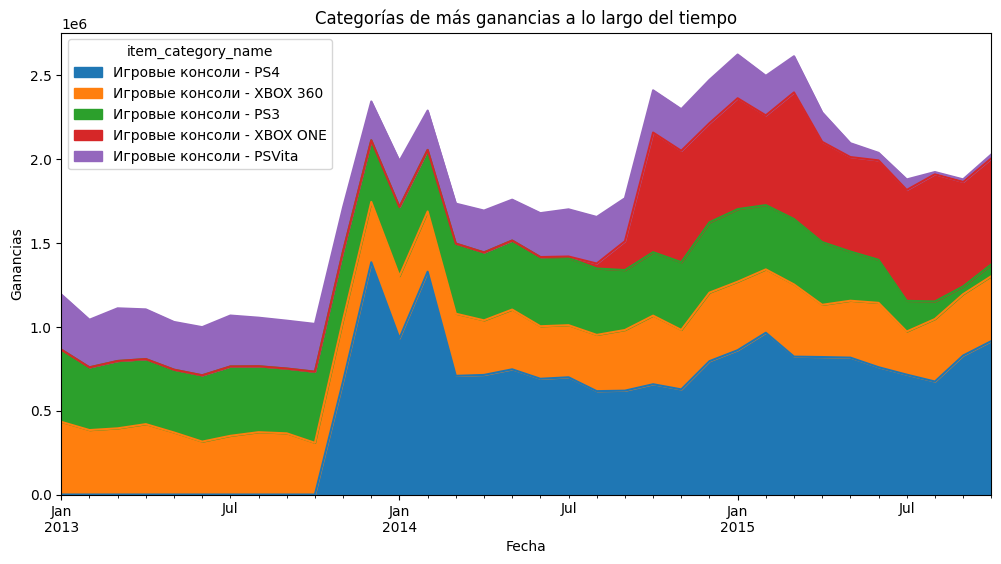

In [ ]:
import matplotlib.dates as mdates
import pandas as pd

sales_by_category = complete_sales_data[complete_sales_data['item_cnt_day'] >= 0]
sales_by_category = sales_by_category.groupby(['date', 'item_category_name'])['revenue'].median().reset_index()
sales_by_category['date'] = pd.to_datetime(sales_by_category['date'], format='%d.%m.%Y')
sales_by_category = sales_by_category.pivot_table(index='date', columns='item_category_name', values='revenue', fill_value=0)

category_totals = sales_by_category.sum().sort_values(ascending=False)

top_categories = category_totals.nlargest(5).index

new_data = sales_by_category[top_categories].copy()

others = sales_by_category.drop(top_categories, axis=1).sum(axis=1)


new_data = new_data.resample('M').sum()

new_data = new_data.fillna(0)

fig, ax = plt.subplots(figsize=(12, 6))
new_data.plot(kind='area', stacked=True, ax=ax)

plt.xlabel('Fecha')
plt.ylabel('Ganancias')
plt.title('Categorías de más ganancias a lo largo del tiempo')
plt.show()

- Las consolas de juegos son las categorías de mayor ganancia.
- PS4 y Xbox One muestran un crecimiento significativo desde 2014.
- PS3 y Xbox 360 declinan gradualmente.

### Tendencias de ventas a lo largo del tiempo:

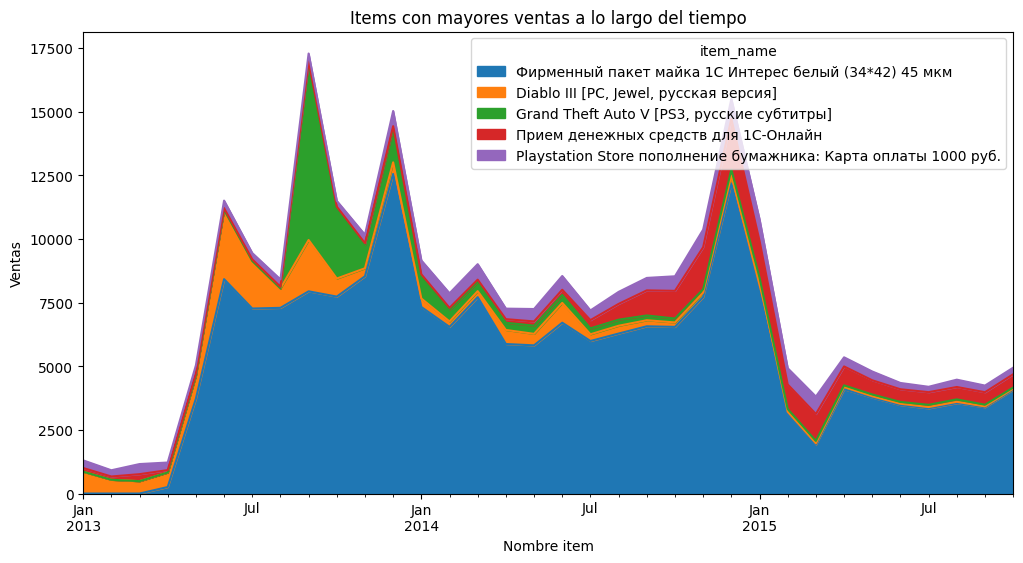

In [ ]:
import matplotlib.dates as mdates
import pandas as pd

sales_by_category = complete_sales_data[complete_sales_data['item_cnt_day'] >= 0]
sales_by_category = sales_by_category.groupby(['date', 'item_name'])['item_cnt_day'].sum().reset_index()
sales_by_category['date'] = pd.to_datetime(sales_by_category['date'], format='%d.%m.%Y')
sales_by_category = sales_by_category.pivot_table(index='date', columns='item_name', values='item_cnt_day', fill_value=0)

category_totals = sales_by_category.sum().sort_values(ascending=False)

top_categories = category_totals.nlargest(5).index

new_data = sales_by_category[top_categories].copy()

others = sales_by_category.drop(top_categories, axis=1).sum(axis=1)

new_data = new_data.resample('M').sum()

new_data = new_data.fillna(0)

fig, ax = plt.subplots(figsize=(12, 6))
new_data.plot(kind='area', stacked=True, ax=ax)

plt.xlabel('Nombre item')
plt.ylabel('Ventas')
plt.title('Items con mayores ventas a lo largo del tiempo')
plt.show()

- Se observa una fuerte estacionalidad en las ventas, con picos pronunciados a mediados de año (probablemente verano) y a finales de año (temporada navideña).
- El producto más vendido consistentemente es un paquete de camisetas de marca 1C. Lo que tiene un factor desproporcionado en la predicción de ventas futuras.
- Hay un patrón cíclico claro, lo que sugiere que las ventas futuras podrían predecirse basándose en patrones históricos.

### Calendario sumarizado de ventas totales

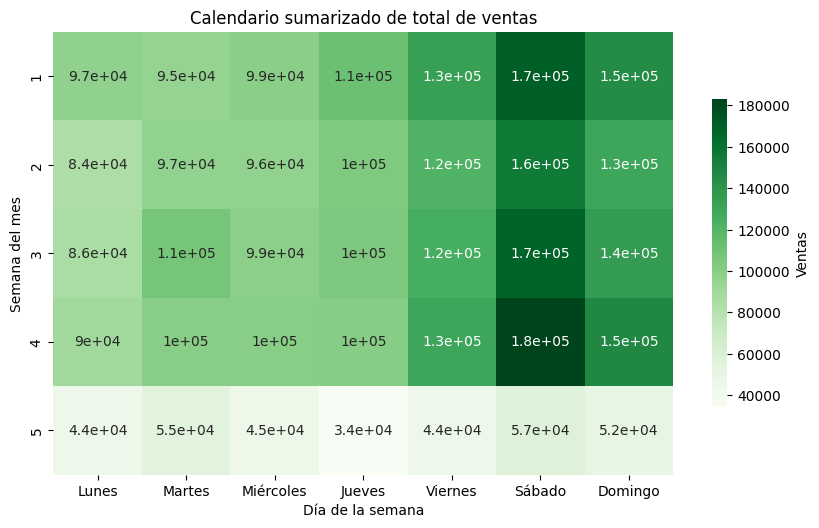

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

calendar = complete_sales_data.copy()
calendar['date'] = pd.to_datetime(calendar['date'], format='%d.%m.%Y')
calendar['day_of_week'] = calendar['date'].dt.dayofweek
calendar['week_of_month'] = (calendar['date'].dt.day - 1) // 7 + 1


day_of_week_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
calendar['day_of_week'] = calendar['day_of_week'].map(day_of_week_map)

median_sales = calendar.groupby(['day_of_week', 'week_of_month'])['item_cnt_day'].sum().reset_index()

pivot_table = median_sales.pivot(index='week_of_month', columns='day_of_week', values='item_cnt_day')

days_of_week = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
pivot_table = pivot_table[days_of_week]

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='Greens', square=True, cbar_kws={'shrink': 0.5, 'label': 'Ventas'})
plt.xlabel('Día de la semana')
plt.ylabel('Semana del mes')
plt.title('Calendario sumarizado de total de ventas')
plt.show()

- Los sábados son consistentemente los días de mayores ventas, y los viernes y domingos en menor medida.
- La variación de las ventas dentro de cada mes podría presagiar la importancia de aprovechar funciones de agregación como la desviación estándar, para extraer features relevantes.


### Distribución de ventas de las 3 categorías más vendidas (izquierda) y precios de categoría por mes (derecha):

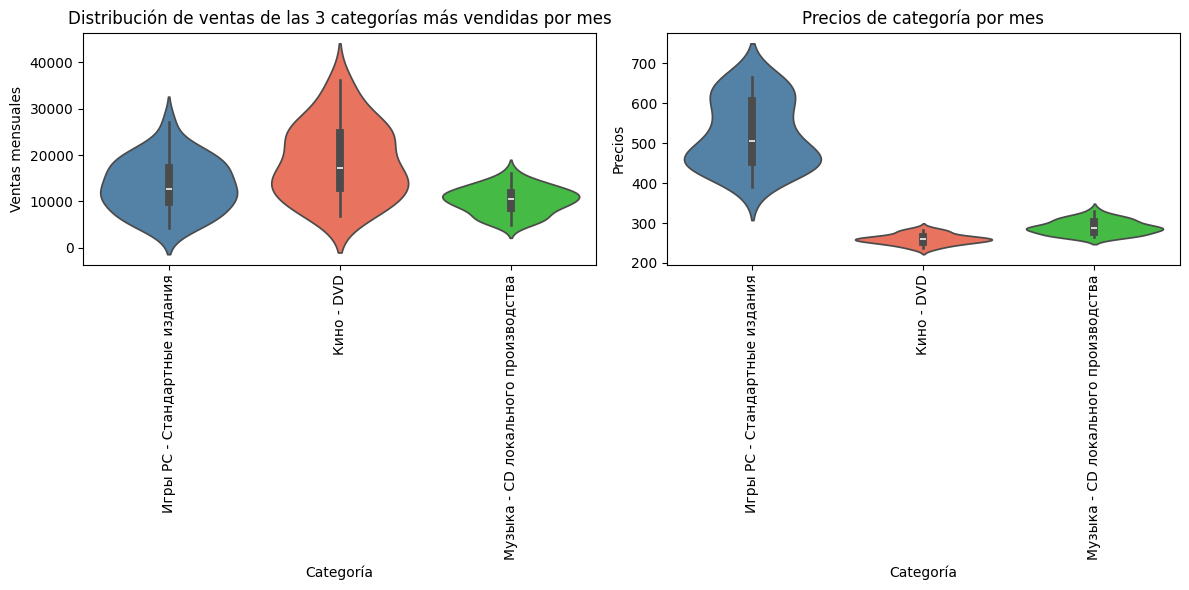

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

total_sales_by_category = complete_sales_data.groupby('item_category_name')['item_cnt_day'].sum().reset_index()
top_categories = total_sales_by_category.nlargest(3, 'item_cnt_day')['item_category_name']

filtered_df_1 = complete_sales_data[complete_sales_data['item_category_name'].isin(top_categories)]
monthly_sales_by_category_1 = filtered_df_1.groupby(['date_block_num', 'item_category_name'])['item_cnt_day'].sum().reset_index()

filtered_df_2 = complete_sales_data[complete_sales_data['item_category_name'].isin(top_categories)]
monthly_sales_by_category_2 = filtered_df_2.groupby(['date_block_num', 'item_category_name'])['item_price'].mean().reset_index()

distinct_colors = ["#FF6347", "#4682B4", "#32CD32"]  # Tomato, SteelBlue, LimeGreen
top_categories_list = top_categories.tolist()
palette_1 = {category: color for category, color in zip(top_categories_list, distinct_colors)}
palette_2 = palette_1

fig, axs = plt.subplots(1, 2, figsize=(12, 6))


sns.violinplot(x='item_category_name', y='item_cnt_day', data=monthly_sales_by_category_1, palette=palette_1, ax=axs[0])
axs[0].set_title('Distribución de ventas de las 3 categorías más vendidas por mes')
axs[0].set_xlabel('Categoría')
axs[0].set_ylabel('Ventas mensuales')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)


sns.violinplot(x='item_category_name', y='item_price', data=monthly_sales_by_category_2, palette=palette_2, ax=axs[1])
axs[1].set_title('Precios de categorías por mes')
axs[1].set_xlabel('Categoría')
axs[1].set_ylabel('Precios')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


- DVD tiene la mayor mediana de ventas mensuales y la distribución más amplia.
- Los juegos de PC tienen una distribución más compacta.
- La música CD tiene las ventas más bajas y la distribución más estrecha.
- Los juegos de PC tienen los precios más altos y la mayor variabilidad.
- DVD y música CD tienen precios más bajos y estables.
- Las fluctuaciones en el precio de los productos podrían tener un impacto significativo en las ventas, sugiriendo la inclusión de elasticidad de precios en el modelo predictivo.
- La relación entre precio y volumen de ventas, especialmente en juegos de PC, sugiere incorporar la elasticidad de precios en el modelo predictivo.
- Hay diferencias significativas en la distribución de ventas y precios entre categorías. Lo 	que se refleja en hechos como que, a pesar de haber más ventas de productos DVD que de PC, estos últimos predicen una mayor ganancia, debido a los precios más elevados.

### Ventas por categoría de producto:

Text(0.5, 1.0, '')

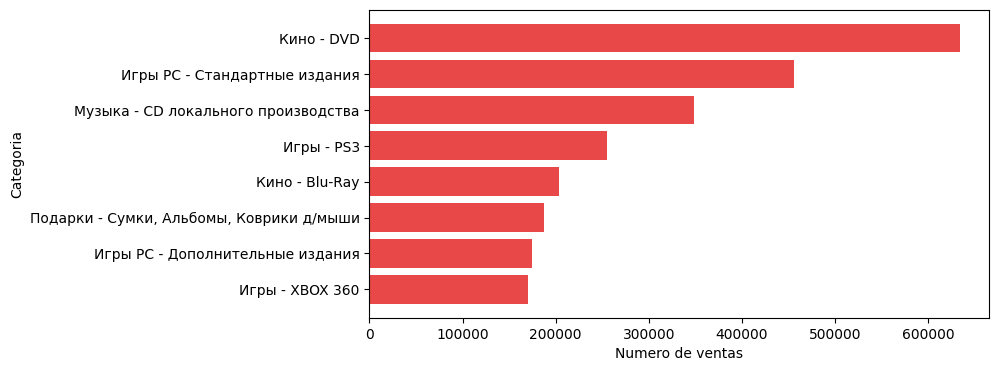

In [ ]:
most_sales_categories = complete_sales_data.groupby('item_category_name').agg({"item_cnt_day": "sum"}).nlargest(8, "item_cnt_day").reset_index()
fig, ax = plt.subplots(figsize = (8,4))
plt.barh(most_sales_categories["item_category_name"], most_sales_categories["item_cnt_day"], color = "#E94848")
ax.invert_yaxis()
ax.set_xlabel("Numero de ventas")
ax.set_ylabel("Categoria")
plt.title("")

- Las películas en DVD son el producto más vendido, seguido por los juegos de PC en edición estándar.
- Los juegos para PS3 y Xbox 360 tienen ventas similares, lo que sugiere una competencia equilibrada en el mercado de consolas.
- La música en CD de producción local tiene ventas significativas, indicando un fuerte mercado doméstico.
- El predominio de ciertas categorías como películas DVD y juegos de PC indica la necesidad de dar mayor peso a estas categorías en las predicciones de ventas futuras.


In [ ]:
new_data.index

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31'],
              dtype='datetime64[ns]', name='date', freq='M')

### Distribución de ventas mensuales (gráfico superior), Ingresos totales mensuales (gráfico central), Cantidad de artículos vendidos por mes (gráfico inferior):

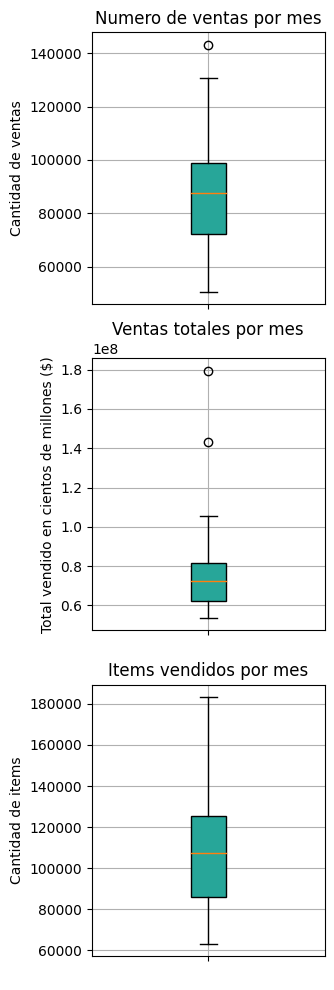

In [ ]:
aggregated_data = complete_sales_data.groupby("date_block_num").agg({"shop_id": "count", "item_price": "sum", "item_cnt_day": "sum"})


fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(3, 12))


axs[0].boxplot(aggregated_data["shop_id"], labels = " ", patch_artist=True, boxprops={'facecolor': '#27A699'})
axs[0].set_ylabel("Cantidad de ventas")
axs[0].set_title("Numero de ventas por mes")
axs[0].grid(True)

axs[1].boxplot(aggregated_data["item_price"], labels = " ", patch_artist=True, boxprops={'facecolor': '#27A699'})
axs[1].set_ylabel("Total vendido en cientos de millones ($)")
axs[1].set_title("Ventas totales por mes")
axs[1].grid(True)

axs[2].boxplot(aggregated_data["item_cnt_day"], labels = " ", patch_artist=True, boxprops={'facecolor': '#27A699'})
axs[2].set_ylabel("Cantidad de items")
axs[2].set_title("Items vendidos por mes")
axs[2].grid(True)

plt.show()

- La mediana de ventas mensuales se sitúa alrededor de 80,000-90,000 unidades.
- Hay una dispersión considerable, con ventas que oscilan entre aproximadamente 50,000 y 140,000 unidades por mes.
- Existen algunos valores atípicos por encima de 140,000, que podrían corresponder a meses de ventas excepcionalmente altas.
- Los ingresos mensuales típicos están entre 60 y 80 millones de rublos.
- Se observan algunos meses con ingresos extraordinariamente altos, superando los 140 millones de rublos.
- Esta variabilidad sugiere la importancia de identificar factores que impulsan estos meses de alto rendimiento.
- La mediana de artículos vendidos por mes es de aproximadamente 110,000.
- Existe una amplia variación, desde unos 60,000 hasta más de 180,000 artículos.
- Esta variabilidad podría estar relacionada con lanzamientos de productos o promociones específicas.


In [ ]:
most_sales_shops = complete_sales_data.groupby('shop_name').agg({"item_cnt_day": "sum"}).nlargest(8, "item_cnt_day").reset_index()
most_sales_shops

,shop_name,item_cnt_day
0,"Москва ТЦ ""Семеновский""",310777.0
1,"Москва ТРК ""Атриум""",241920.0
2,"Химки ТЦ ""Мега""",185790.0
3,"Москва ТЦ ""МЕГА Теплый Стан"" II",184557.0
4,"СПб ТК ""Невский Центр""",144934.0
5,"Якутск Орджоникидзе, 56",141107.0
6,"Москва ТЦ ""МЕГА Белая Дача II""",136657.0
7,"Воронеж (Плехановская, 13)",100489.0


<Axes: xlabel='shop_name', ylabel='item_category_name'>

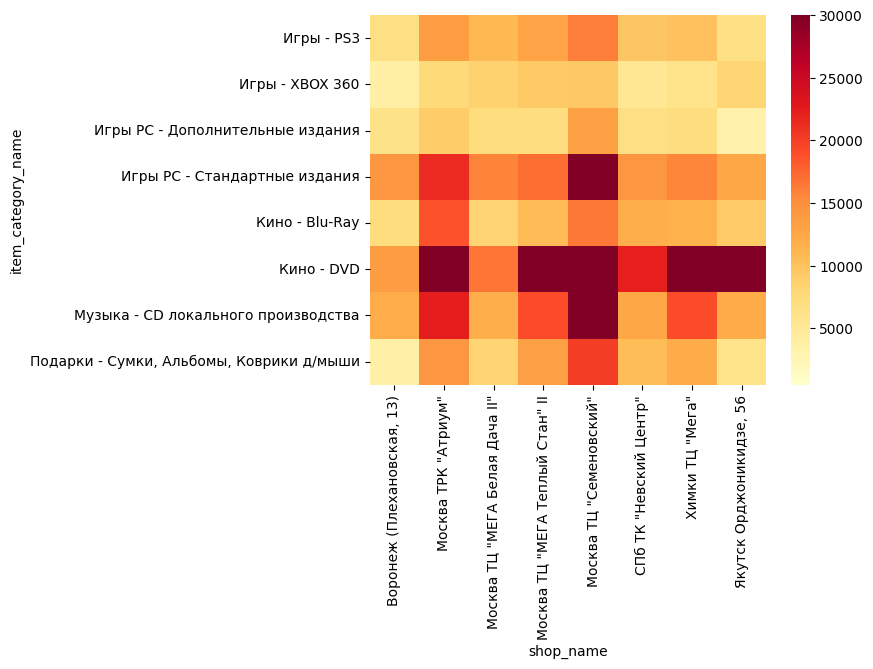

In [ ]:
item_category_and_shop_name = complete_sales_data.groupby(["item_category_name", "shop_name"]).agg({"item_cnt_day": "sum"}).reset_index()
merged = pd.merge(most_sales_categories, item_category_and_shop_name, on = "item_category_name",how = "left")
merged2 = pd.merge(most_sales_shops, merged, on = "shop_name", how = "left").drop("item_cnt_day_x", axis = 1)
merged3 = merged2.drop("item_cnt_day", axis = 1)

pivot = merged3.pivot(index = "item_category_name", columns = "shop_name", values = "item_cnt_day_y")
sns.heatmap(pivot, cmap = "YlOrRd", vmin = 500, vmax = 30000)

### Detección de valores atípicos en la cantidad de ventas, precios y ganancias

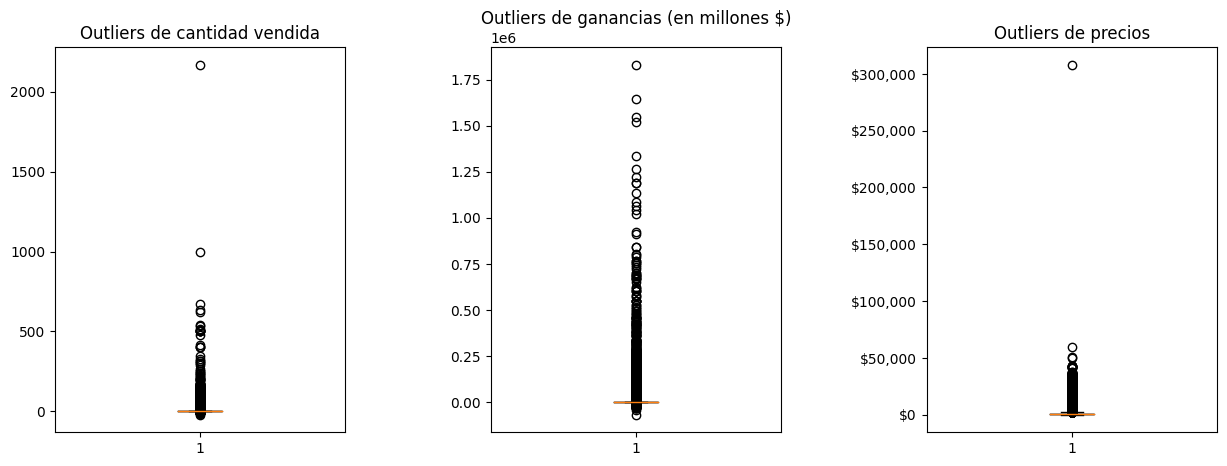

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].boxplot(complete_sales_data["item_cnt_day"])
ax[0].set_title("Outliers de cantidad vendida")

ax[1].boxplot(complete_sales_data["revenue"])
ax[1].set_title("Outliers de ganancias (en millones $)")

ax[2].boxplot(complete_sales_data["item_price"])
ax[2].set_title("Outliers de precios")
yticks = ax[2].get_yticks()
ax[2].set_yticklabels(['${:,.0f}'.format(x) for x in yticks])

fig.subplots_adjust(wspace=0.5)
plt.show()

Vemos que podríamos sacar los outliers más anómalos que más se alejan del rango intercuartil, como es el caso de artículos con precios mayores a $80.000 y artículos con más de 900 ventas. 

In [ ]:
# Saco los outliers más anómalos que más se alejan del rango intercuartil y distorsionan la escala del eje y
complete_sales_data = complete_sales_data[complete_sales_data.item_price<80000]
complete_sales_data = complete_sales_data[complete_sales_data.item_cnt_day<900]

# Feature engineering

Desagregamos la fecha:

In [ ]:
complete_sales_data['date'] = pd.to_datetime(complete_sales_data['date'], format='%d.%m.%Y')
complete_sales_data['year'] = complete_sales_data['date'].dt.year
complete_sales_data['month'] = complete_sales_data['date'].dt.month
complete_sales_data['week'] = complete_sales_data['date'].dt.isocalendar().week

In [ ]:
funcs = ['sum', 'median', 'mean', 'std']
agg_funcs = {
    'item_cnt_day': funcs,
    'item_price': funcs,
    'revenue': funcs
}

cols = ['item_cnt_day','item_price','revenue']

agg_func_names = [f"{func}_{col}" for col in cols for func in funcs]


mensual = complete_sales_data.groupby(['date_block_num', 'shop_id', 'item_id']).agg(agg_funcs).reset_index()
mensual.columns = ['date_block_num', 'shop_id', 'item_id'] + ['monthly_' + name for name in agg_func_names]
complete_sales_data = pd.merge(complete_sales_data, mensual, on=['date_block_num', 'shop_id', 'item_id'], how='right')

  La información de ciudad, tipo y subtipo fueron encodeadas mediante target encoding, generalización de mean encoding pero con otras funciones de agregación además del mean (la suma, la mediana y la desviación estándar). Como las columnas tienen muchas categorías (hasta más de 60), el one-hot encoding sería muy costoso. Además, como el mean o target encoding es con lag, no hay data leakage:

In [ ]:
## Target encoding, generalización de mean encoding pero con otras funciones de agregación. Las columnas que estoy encodeando tienen muchas categorías, por lo que one-hot encoding sería muy costoso ##
# Features por tipo
tipos = complete_sales_data.groupby(['date_block_num', 'shop_id', 'type']).agg(agg_funcs).reset_index()
tipos.columns = ['date_block_num', 'shop_id', 'type'] + ['tipo_' + name for name in agg_func_names]
complete_sales_data = pd.merge(complete_sales_data, tipos, on=['date_block_num', 'shop_id', 'type'], how='left')

# Features por subtipo
subtipos = complete_sales_data.groupby(['date_block_num', 'shop_id', 'subtype']).agg(agg_funcs).reset_index()
subtipos.columns = ['date_block_num', 'shop_id', 'subtype'] + ['subtipo_' + name for name in agg_func_names]
complete_sales_data = pd.merge(complete_sales_data, subtipos, on=['date_block_num', 'shop_id', 'subtype'], how='left')

# Features por ciudad
ciudades = complete_sales_data.groupby(['date_block_num', 'item_id', 'city']).agg(agg_funcs).reset_index()
ciudades.columns = ['date_block_num', 'item_id', 'city'] + ['ciudad_' + name for name in agg_func_names]
complete_sales_data = pd.merge(complete_sales_data, ciudades, on=['date_block_num', 'item_id', 'city'], how='left')

Fueron utilizadas la suma, la media, la mediana y la desviación estándar de la cantidad de ventas mensuales (item_cnt_month), del precio y las ganancias. Esto fue empleado con lags de 1, 2, 3 y 6 meses. Los lags ayudan a revelar tendencias, estacionalidad y otros patrones temporales que son esenciales para entender y pronosticar el comportamiento del time series, lo que es crucial en el contexto en el que el objetivo es predecir valores futuros:


In [ ]:
print(complete_sales_data["date_block_num"].max())
# Incluir al test set para agregarle lag features para la predicción de Kaggle
test['date_block_num'] = 34
test['year'] = 2015
test['month'] = 11
complete_sales_data = pd.concat([complete_sales_data, test], keys=['date_block_num','shop_id','item_id'], ignore_index=True)

# Lag por meses
for lag in [1, 2, 3, 6]:
    for name in agg_func_names:
        # Experimentalmente vimos que hacer fillna con 0 cambia la performance del modelo de manera insignificante en comparación con mean, ffill (llenar con el último no null) o bfill (llenar con el primer no null)
        # Casteamos a int para que consuma menos memoria
        complete_sales_data[f'monthly_{name}_lag_{lag}'] = complete_sales_data.groupby(['shop_id', 'item_id'])[f'monthly_{name}'].shift(lag).fillna(0).astype(int)

   - Las columnas de lag tienen muchos nulos en relación al orden cronológico (los que no tienen valor previo según el lag). Evaluamos hacer imputing con el primer valor no nulo del time series o el último, usando la mayor cantidad de datos posibles para el training set, así no están sesgados por la manera en que se hace el fill de los nans.
   - Experimentalmente vimos que hacer fillna con 0 cambia la performance del modelo de manera insignificante en comparación con mean, ffill (llenar con el último no null) o bfill (llenar con el primer no null).
   - Casteamos las features creadas a int para que consuma menos memoria.


Acá le agregamos el lag a ciudad, tipo y subtipo:

In [ ]:
# Como el mean o target encoding es con lag, no hay data leakage
lag = 1
for name in agg_func_names:
    # Experimentalmente vimos que hacer fillna con 0 cambia la performance del modelo de manera insignificante en comparación con mean, ffill (llenar con el último no null) o bfill (llenar con el primer no null)
    # Casteamos a int para que consuma menos memoria
    complete_sales_data[f'tipo_{name}_lag_{lag}'] = complete_sales_data.groupby(['shop_id', 'type'])[f'tipo_{name}'].shift(lag).fillna(0).astype(int)
    complete_sales_data[f'subtipo_{name}_lag_{lag}'] = complete_sales_data.groupby(['shop_id', 'subtype'])[f'subtipo_{name}'].shift(lag).fillna(0).astype(int)
    complete_sales_data[f'ciudad_{name}_lag_{lag}'] = complete_sales_data.groupby(['shop_id', 'city'])[f'ciudad_{name}'].shift(lag).fillna(0).astype(int)

complete_sales_data.rename(columns={'monthly_sum_item_cnt_day':'item_cnt_month'}, inplace=True)

agg_func_names.remove('sum_item_cnt_day')

## Drop features del presente ##
features = []
for name in agg_func_names:
    if f'monthly_{name}' in complete_sales_data.columns:
        features.append(f'monthly_{name}')
# Drop features por tipo
for name in agg_func_names:
    if f'monthly_{name}' in complete_sales_data.columns:
        features.append(f'tipo_{name}')
# Drop features por subtipo
for name in agg_func_names:
    if f'monthly_{name}' in complete_sales_data.columns:
        features.append(f'subtipo_{name}')
# Drop features por ciudad
for name in agg_func_names:
    if f'monthly_{name}' in complete_sales_data.columns:
        features.append(f'ciudad_{name}')

complete_sales_data.drop(features, axis=1, inplace=True)

Se aplicó one-hot encoding para el año. Como solo hay 3 años, no es una operación costosa:


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
encoded_years = encoder.fit_transform(complete_sales_data[['year']])
encoded_years_df = pd.DataFrame(encoded_years, columns=encoder.get_feature_names_out(['year']))
complete_sales_data = pd.concat([complete_sales_data, encoded_years_df], axis=1)
complete_sales_data.drop('year', axis=1, inplace=True)

- Eliminamos columnas que no usaremos en los modelos
- Debido a la manera en la que se deben hacer joins durante el proceso de feature engineering se generan muchos duplicados que deben ser eliminados. 

In [ ]:
print(complete_sales_data.isna().any(axis=1).sum())
print(complete_sales_data.isna().any(axis=0))

columns_to_drop = ['date', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'revenue', 'city', 'type', 'subtype',
       'week', 'tipo_sum_item_cnt_day',
       'subtipo_sum_item_cnt_day', 'ciudad_sum_item_cnt_day']
complete_sales_data.drop(columns_to_drop, axis=1, inplace=True)


# Cantidad de duplicados (se generan más duplicados porque al joinear se necesita el df diario original)
print(f"duplicados: {complete_sales_data.duplicated().sum()}")
complete_sales_data.drop_duplicates(inplace=True)


complete_sales_data

33
3150040
date                          True
date_block_num               False
shop_id                      False
item_id                      False
item_price                    True
                             ...  
subtipo_std_revenue_lag_1    False
ciudad_std_revenue_lag_1     False
year_2013                    False
year_2014                    False
year_2015                    False
Length: 108, dtype: bool
duplicados: 329629


,date_block_num,shop_id,item_id,month,item_cnt_month,ID,monthly_sum_item_cnt_day_lag_1,monthly_median_item_cnt_day_lag_1,monthly_mean_item_cnt_day_lag_1,monthly_std_item_cnt_day_lag_1,...,ciudad_median_revenue_lag_1,tipo_mean_revenue_lag_1,subtipo_mean_revenue_lag_1,ciudad_mean_revenue_lag_1,tipo_std_revenue_lag_1,subtipo_std_revenue_lag_1,ciudad_std_revenue_lag_1,year_2013,year_2014,year_2015
0,0,0,32,1,6.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0.0,0.0
1,0,0,32,1,6.0,0.0,6,1,1,0,...,221,247,196,287,318,187,106,1.0,0.0,0.0
2,0,0,32,1,6.0,0.0,6,1,1,0,...,221,247,196,287,318,187,106,1.0,0.0,0.0
3,0,0,32,1,6.0,0.0,6,1,1,0,...,221,247,196,287,318,187,106,1.0,0.0,0.0
4,0,0,33,1,3.0,0.0,0,0,0,0,...,221,247,0,287,318,0,106,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150035,34,45,18454,11,1.0,214195.0,1,1,1,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
3150036,34,45,16188,11,1.0,214196.0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
3150037,34,45,15757,11,1.0,214197.0,1,1,1,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
3150038,34,45,19648,11,1.0,214198.0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0


In [ ]:
complete_sales_data.to_csv("preprocessed.csv")

In [ ]:
complete_sales_data = pd.read_csv("preprocessed.csv")

### Selección de datos de validación:



- La competencia sólo nos pide predecir un mes.
- Los splits están hechos de manera que no haya data leakage (no se usan datos futuros para predecir el pasado, o time travel).
- Se utilizaron datos hasta el mes 33 para entrenamiento.
- El mes 33 se usó para validación.
- El mes 34 se reservó para las predicciones finales de la competencia.

Esta estrategia permite una validación robusta sin filtración de datos futuros.

In [ ]:
# Los lags generan muchas nans por lo que usamos la mayor cantidad de datos posibles para el training set, así no estan sesgados por la manera en que se hace el fill de los nans.
# Además, la competencia de Kaggle nos pide predecir sólo un mes.
# Los splits están hechos de manera que no haya data leakage (no se usan datos futuros para predecir el pasado, o time travel).

complete_sales_data.fillna(0, inplace=True)
x_train = complete_sales_data[complete_sales_data['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
y_train = complete_sales_data[complete_sales_data['date_block_num'] < 33]['item_cnt_month']

x_valid = complete_sales_data[complete_sales_data['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
y_valid = complete_sales_data[complete_sales_data['date_block_num'] == 33]['item_cnt_month']

x_test = complete_sales_data[complete_sales_data['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
complete_sales_data.to_csv('preprocesado.csv')

# Modelos

### Baseline

Vamos a desarrollar un modelo sencillo que servirá como referencia inicial (baseline) en nuestro trabajo de machine learning. Este modelo básico nos permitirá comprender cómo funciona un enfoque fundamental y nos proporcionará un punto de partida sobre el cual podremos mejorar. Para este propósito, implementaremos un regresor lineal y evaluaremos su rendimiento.
Nuestro objetivo es establecer un piso de rendimiento que nos indique qué valores esperar antes de pasar a modelos más complejos. Comenzamos con un modelo de regresión lineal debido a su simplicidad y facilidad de interpretación. Este enfoque nos ayudará a identificar y capturar patrones más complejos en futuros modelos. Al finalizar, logramos un error (RMSE) de 4.3789, el cual servirá como punto de comparación para evaluar la mejora en los modelos subsecuentes.


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(x_train, y_train)

LinearRegression()

In [ ]:
#informativo
lr.coef_

array([ 4.07951880e+04,  1.01671575e-03, -4.89442289e-06, -4.07951691e+04,
       -3.96205678e-07,  9.57285502e-01, -2.16967288e-02, -1.25963078e+00,
       -8.10765888e-01, -1.27043639e-05,  3.74359216e-04, -7.66193760e-04,
       -6.38601457e-04, -1.35936950e-05, -4.97619453e-07,  3.14602233e-04,
       -1.56602943e-04, -1.79264734e-04,  1.69410155e-01, -3.03987528e-01,
        1.50193406e-01,  4.30539149e-06, -2.43712539e-05,  1.19945927e-04,
        2.15732616e-04,  1.18659136e-06,  1.31722828e-04, -2.06092695e-04,
        8.29446926e-05, -1.96749506e-03, -2.82670241e-01,  2.71243126e-01,
       -1.87822790e-01, -4.33171408e-06,  2.43770214e-04, -3.67160585e-04,
        2.19263611e-04, -7.36576112e-07, -2.57080089e-05,  1.12031232e-04,
       -4.95549423e-05, -1.49969051e-02,  7.76554983e-02, -1.47744099e-01,
       -1.13346547e-01,  2.52524276e-05,  1.00079577e-04, -1.97555808e-04,
        5.45368791e-04, -1.66779055e-05, -1.05298010e-04,  1.79135282e-04,
        4.23905817e-06,  

In [ ]:
#informativo
lr.intercept_

-448747.5886343045

In [ ]:
y_preds = lr.predict(x_valid)
y_train_pred = lr.predict(x_train)

# Este ultimo son las predicciones para kaggle
test_preds = lr.predict(x_test)

In [ ]:
y_preds

array([1.00928306, 1.02496766, 3.1471916 , ..., 2.46681775, 1.08905071,
       1.80927227])

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
mean_squared_error(y_valid, y_preds)

19.17518289581178

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from math import sqrt

# Crear el modelo de regresión lineal
lr = LinearRegression()
lr.fit(x_train, y_train)
y_preds = lr.predict(x_valid)
sqrt(mean_squared_error(y_valid, y_preds))

# RMSE = 4.378948152766019

In [ ]:
mean_absolute_error(y_train, y_train_pred)

1.0996834360613208

In [ ]:
#Esto sirve para descargar el modelo entrenado.
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.1 MB/s eta 0:00:00


In [ ]:
joblib.dump(lr, 'model.pkl')

['model.pkl']

La búsqueda de hiperparámetros en xgboost y lgbm fue realizada utilizando un proceso de optimización bayesiana, en donde se define un espacio de búsqueda para los hiperparámetros que se desean optimizar. En este caso, se definió el espacio de búsqueda especificando los rangos y distribuciones de cada hiperparámetro.

Se construye un modelo de probabilidad sustituto que intenta aprender la relación entre los hiperparámetros y la métrica de evaluación (en este caso RMSE en el conjunto de validación).

Se define una función objetivo objective que toma los hiperparámetros propuestos como entrada, crea un modelo LightGBM (o xgboost) con esos hiperparámetros, lo entrena y devuelve la métrica de evaluación (RMSE) en el conjunto de validación.

Se llama a la función fmin de Hyperopt, que es el optimizador bayesiano. Se le pasa la función objetivo objective, el espacio de búsqueda space, el algoritmo de optimización tpe.suggest (Tree-structured Parzen Estimator), el objeto Trials y el número máximo de evaluaciones max_evals=50.


### XGBoost

In [ ]:
# reproducibilidad
seed = 42
random.seed(seed)
np.random.seed(seed)



In [ ]:
!pip install hyperopt
!pip install xgboost
from hyperopt import fmin, tpe, Trials, hp
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


Se probaron varios modelos de xgboost con búsqueda de hiperparametros. Este fue el que obtuvo mejor resultado en kaggle para xgboost. Se realizaron varias busquedas bayesianas enfocando en solo algunos hiperparametros para tratar de mejorar los resultados, lo cual se logró en validación (RMSE = 3.79665 comparado con 4.27) pero predicciones de kaggle de hasta 3.19.  


In [ ]:
## Xgboost con optimización bayesiana de hipermarámetros
from hyperopt import fmin, tpe, Trials, hp
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

space = {
    "lr": hp.uniform("lr", 0.01, 0.2),
    "min_child_weight": hp.quniform("min_child_weight", 11, 14, 1),
    "max_depth": hp.quniform("max_depth", 5, 50, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
    "alpha": hp.uniform("alpha", 0.1, 100),
    "subsample": hp.uniform("subsample", 0.1, 1)
}



def evaluate_model(params):
    lr = params["lr"]
    min_child_weight = int(params["min_child_weight"])
    max_depth = int(params["max_depth"])
    colsample_bytree = params["colsample_bytree"]
    alpha = params["alpha"]
    subsample = params["subsample"]

    model = XGBRegressor(
        learning_rate= lr, # 0.0722241787470296
        min_child_weight= min_child_weight, # antes 13
        max_depth= max_depth, # 21
        colsample_bytree = colsample_bytree, #0.5571892732675109
        alpha= alpha, #antes 85.53988605179686,
        subsample= subsample, # antes 0.7518329545920156
        n_estimators= 5000,
        seed=42
    )

    print(alpha, colsample_bytree, lr, max_depth, min_child_weight, subsample)

    model.fit(x_train,y_train, eval_metric="rmse", early_stopping_rounds=15,eval_set=[(x_train, y_train), (x_valid, y_valid)], verbose=True)
    y_pred = model.predict(x_valid)
    return mean_squared_error(y_valid, y_pred)

trials = Trials()
# agrego rstate=np.random.RandomState(seed) para que sea reproducible
best = fmin(evaluate_model, space, algo=tpe.suggest, trials=trials, max_evals=100, rstate=np.random.RandomState(42))

print("Best parameters:", best)


17.208751115945514
0.5715899597430276
0.1942042277776602
27
14
0.20821093613252498
[0]	validation_0-rmse:12.19225	validation_1-rmse:9.56749
[1]	validation_0-rmse:10.44262	validation_1-rmse:8.03719
[2]	validation_0-rmse:9.04906	validation_1-rmse:6.90507
[3]	validation_0-rmse:7.90954	validation_1-rmse:6.17784
[4]	validation_0-rmse:7.04974	validation_1-rmse:5.57257
[5]	validation_0-rmse:6.36319	validation_1-rmse:5.21392
[6]	validation_0-rmse:5.85933	validation_1-rmse:4.94755
[7]	validation_0-rmse:5.45439	validation_1-rmse:4.65830
[8]	validation_0-rmse:5.16553	validation_1-rmse:4.55107
[9]	validation_0-rmse:4.94801	validation_1-rmse:4.66323
[10]	validation_0-rmse:4.79040	validation_1-rmse:4.72843
[11]	validation_0-rmse:4.66028	validation_1-rmse:4.70387
[12]	validation_0-rmse:4.58849	validation_1-rmse:4.67092
[13]	validation_0-rmse:4.46916	validation_1-rmse:4.67893
[14]	validation_0-rmse:4.39165	validation_1-rmse:4.60569
[15]	validation_0-rmse:4.29075	validation_1-rmse:4.71199
[16]	validati

[0]	validation_0-rmse:13.62192	validation_1-rmse:10.75807
[1]	validation_0-rmse:12.77174	validation_1-rmse:10.02565
[2]	validation_0-rmse:12.00793	validation_1-rmse:9.32936
[3]	validation_0-rmse:11.28311	validation_1-rmse:8.77598
[4]	validation_0-rmse:10.62952	validation_1-rmse:8.23325
[5]	validation_0-rmse:10.02523	validation_1-rmse:7.74581
[6]	validation_0-rmse:9.45182	validation_1-rmse:7.33307
[7]	validation_0-rmse:8.93411	validation_1-rmse:6.93126
[8]	validation_0-rmse:8.43895	validation_1-rmse:6.55635
[9]	validation_0-rmse:7.99407	validation_1-rmse:6.21863
[10]	validation_0-rmse:7.57236	validation_1-rmse:5.92619
[11]	validation_0-rmse:7.20048	validation_1-rmse:5.70052
[12]	validation_0-rmse:6.84850	validation_1-rmse:5.46985
[13]	validation_0-rmse:6.51349	validation_1-rmse:5.29057
[14]	validation_0-rmse:6.21952	validation_1-rmse:5.14576
[15]	validation_0-rmse:5.94366	validation_1-rmse:4.97916
[16]	validation_0-rmse:5.69848	validation_1-rmse:4.84073
[17]	validation_0-rmse:5.46759	va

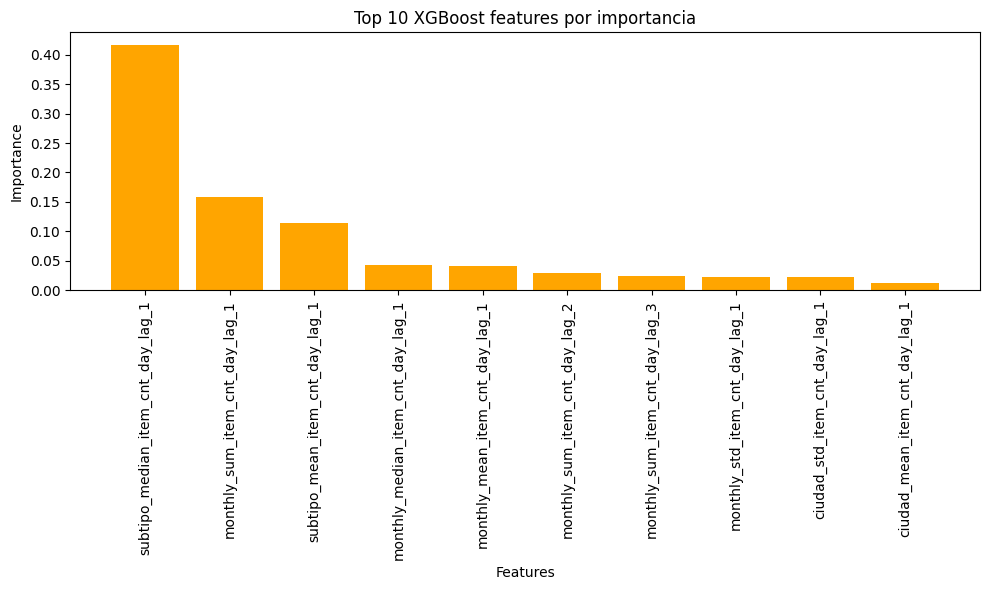

In [ ]:
from xgboost import XGBRegressor
modelXG = XGBRegressor(
        learning_rate= 0.0722241787470296,
        min_child_weight= 13, # antes 15
        max_depth= 21,
        colsample_bytree = 0.5571892732675109,
        alpha=85.53988605179686, #antes63.33141702252051,
        subsample= 0.7518329545920156,
        n_estimators= 5000,
        seed=42
    )
modelXG.fit(x_train,y_train, eval_metric="rmse", early_stopping_rounds=50,eval_set=[(x_train, y_train), (x_valid, y_valid)], verbose=True)

y_predsXG = modelXG.predict(x_test)
#Validation 1
#Minimo rmse: 3.79665

feature_importances = modelXG.feature_importances_
feature_names = x_train.columns

top_10_indices = np.argsort(feature_importances)[::-1][:10]
top_10_features = [feature_names[i] for i in top_10_indices]
top_10_importances = [feature_importances[i] for i in top_10_indices]

zero_importance_features = [feature for feature, importance in zip(feature_names, feature_importances) if importance == 0]
if zero_importance_features:
    print("Features con importancia de 0:")
    for feature in zero_importance_features:
        print(f"- {feature}")
else:
    print("No hay features con importancia de 0.")

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_10_importances)), top_10_importances, color='orange')
plt.xticks(range(len(top_10_features)), top_10_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 XGBoost features por importancia')
plt.tight_layout()
plt.show()

In [ ]:
#XGBoost Parameters Submission 0
#Best parameters: {'alpha': 64.00125052748176, 'colsample_bytree': 0.8613619690359112, 'lr': 0.01648131693772629, 'max_depth': 10.0, 'min_child_weight': 9.0, 'subsample': 0.7754221494005991}
# Con early_stopping = 50

#Mejor Modelo en Kaggle

In [ ]:
#XGBoost Parameters Submission 1
#Otros parameters: {'alpha': 24.288108584027707, 'colsample_bytree': 0.5298723551788975, 'lr': 0.05569016381359883, 'max_depth': 53.0, 'min_child_weight': 56.0, 'n_estimators': 5000.0, 'subsample': 0.7635941690830103}
# Con early_stopping = 1

In [ ]:
#XGBoost Parameters Submission 2
#XGBRegressor( learning_rate= 0.0722241787470296, min_child_weight= 13,max_depth= 21,colsample_bytree = 0.5571892732675109,alpha=85.53988605179686,subsample= 0.7518329545920156, n_estimators= 56,seed=42)

In [ ]:
#XGBoost Parameters Submission 3
#XGBRegressor( learning_rate= 0.0722241787470296, min_child_weight= 13,max_depth= 21,colsample_bytree = 0.5571892732675109,alpha=85.53988605179686,subsample= 0.7518329545920156, n_estimators= 5000,seed=42)
# Con early_stopping = 50

In [ ]:
!pip install hyperopt

### Lightgbm

100%|██████████| 50/50 [2:14:47<00:00, 161.75s/trial, best loss: 3.316101803081459]
Features con importancia de 0:
- date_block_num
- item_id
- ID
- monthly_mean_revenue_lag_2
- monthly_mean_item_price_lag_3
- monthly_sum_revenue_lag_3
- monthly_median_revenue_lag_3
- monthly_sum_item_price_lag_6
- monthly_mean_item_price_lag_6
- monthly_sum_revenue_lag_6
- monthly_median_revenue_lag_6
- tipo_mean_item_price_lag_1
- subtipo_mean_revenue_lag_1
- tipo_std_revenue_lag_1
- year_2013
- year_2014


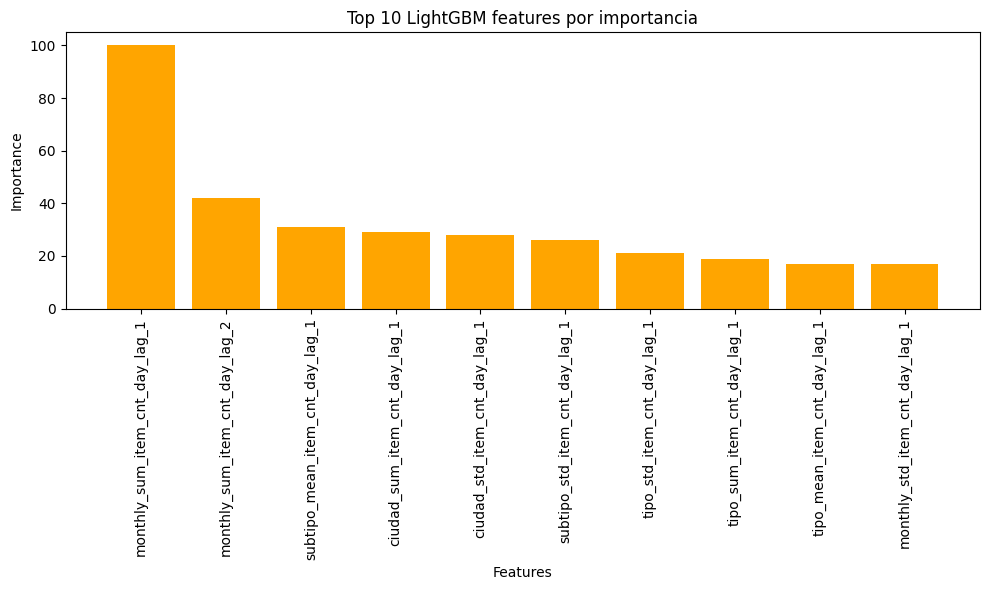

In [ ]:
import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, Trials, hp, STATUS_OK
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)

space = {
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 200, 10),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
}

def objective(params):
    max_depth = int(params['max_depth'])
    num_leaves = int(params['num_leaves'])
    min_child_samples = int(params['min_child_samples'])
    learning_rate = params['learning_rate']
    subsample = params['subsample']
    colsample_bytree = params['colsample_bytree']
    reg_alpha = params['reg_alpha']
    reg_lambda = params['reg_lambda']

    model = LGBMRegressor(
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=seed,
        n_estimators=1000,
        verbose=-1
    )
    early_stop = lgb.early_stopping(stopping_rounds=50, verbose=False)
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], callbacks=[early_stop])

    y_pred = model.predict(x_valid)
    val_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

    return {'loss': val_rmse, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=np.random.RandomState(seed))

best_model = trials.best_trial['result']['model']

best_model.booster_.save_model('best_lgbm_model.txt')

feature_importances = best_model.feature_importances_
feature_names = x_train.columns

top_10_indices = np.argsort(feature_importances)[::-1][:10]
top_10_features = [feature_names[i] for i in top_10_indices]
top_10_importances = [feature_importances[i] for i in top_10_indices]

zero_importance_features = [feature for feature, importance in zip(feature_names, feature_importances) if importance == 0]
if zero_importance_features:
    print("Features con importancia de 0:")
    for feature in zero_importance_features:
        print(f"- {feature}")
else:
    print("No hay features con importancia de 0.")

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_10_importances)), top_10_importances, color='orange')
plt.xticks(range(len(top_10_features)), top_10_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 LightGBM features por importancia')
plt.tight_layout()
plt.show()
# RMSE con val set = 3.316101803081459

Las features más importantes del LightGBM, el modelo con mejor rmse en la competencia fueron:

1. Ventas mensuales sumarizadas con lag de 1 mes.
2. Ventas mensuales sumarizadas con lag de 2 meses.
3. Promedio de ventas por mes por subtipo con lag de 1 mes.
4. Ventas mensuales sumarizadas por ciudad con lag de 1 mes.
5. Desviación estándar de ventas mensuales por ciudad con lag de 1 mes.
6. Desviación estándar de ventas mensuales por subtipo con lag de 1 mes.
7. Desviación estándar de ventas mensuales por tipo con lag de 1 mes.
8. Ventas mensuales sumarizadas por tipo con lag de 1 mes.
9. Promedio de ventas por mes por tipo con lag de 1 mes.
10. Desviación estándar de ventas mensuales con lag de 1 mes.

Features con importancia de 0: date_block_num,monthly_mean_revenue_lag_2 (promedio mensual de ingresos con lag de 2 meses), monthly_mean_item_price_lag_3 (precio promedio mensual de artículos con lag de 3 meses), monthly_sum_revenue_lag_3-monthly_median_revenue_lag_3 (diferencia entre suma mensual y mediana mensual de ingresos, ambas con lag de 3 meses), monthly_sum_item_price_lag_6 (suma mensual de precios de artículos con lag de 6 meses), monthly_mean_item_price_lag_6 (precio promedio mensual de artículos con lag de 6 meses), monthly_sum_revenue_lag_6 (suma mensual de ingresos con lag de 6 meses), monthly_median_revenue_lag_6 (mediana mensual de ingresos con lag de 6 meses), tipo_mean_item_price_lag_1 (precio promedio de artículos por tipo de producto con lag de 1 mes), subtipo_mean_revenue_lag_1 (ingreso promedio por subtipo de producto con lag de 1 mes), tipo_std_revenue_lag_1 (desviación estándar de ingresos por tipo de producto con lag de 1 mes), year_2013, year_2014.

- Se puede apreciar que en ambos modelos no fue predominante el uso de features con muchos meses de lag y que fue la venta total mensual con un mes de lag el factor más pronunciadamente importante.


In [ ]:
import pickle
with open('modelXG.pkl', 'rb') as f:
    best_model = pickle.load(f)

feature_importances = best_model.feature_importances_
feature_names = x_train.columns
top_10_indices = np.argsort(feature_importances)[::-1][:10]
top_10_features = [feature_names[i] for i in top_10_indices]
top_10_importances = [feature_importances[i] for i in top_10_indices[1:]]

zero_importance_features = [feature for feature, importance in zip(feature_names, feature_importances) if importance == 0]
if zero_importance_features:
    print("Features with zero importance:")
    for feature in zero_importance_features:
        print(f"- {feature}")
else:
    print("No features with zero importance.")


from xgboost import plot_importance
plot_importance(best_model, max_num_features=10, color = 'orange', importance_type='cover')
plt.title('Xgboost: Top 10 features por importancia')


# Features with zero importance:
# - monthly_mean_item_cnt_day_lag_1

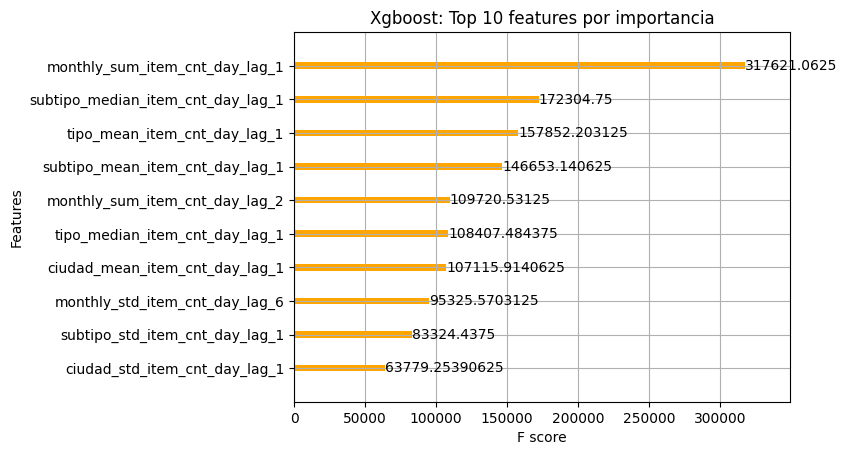

Las features más importantes del XGBoost:

1. Ventas mensuales sumarizadas con lag de 1 mes.
2. Mediana de ventas por mes por subtipo con lag de 1 mes.
3. Promedio de ventas por mes por tipo con lag de 1 mes.
4. Promedio de ventas por mes por subtipo con lag de 1 mes.
5. Ventas mensuales sumarizadas con lag de 2 meses.
6. Mediana de ventas por mes por tipo con lag de 1 mes.
7. Promedio de ventas por mes por ciudad con lag de 1 mes.
8. Desviación estándar de ventas mensuales con lag de 6 meses.
9. Desviación estándar de ventas mensuales por subtipo con lag de 1 meses.
10. Desviación estándar de ventas mensuales por ciudad con lag de 1 mes.

Features con importancia de 0: 	monthly_mean_item_cnt_day_lag_1 (promedio de ventas por mes con lag de 1 mes)


### Red neuronal:

Los datos de entrada se normalizan utilizando MinMaxScaler para estandarizar la escala de las features, necesario para el uso de redes neuronales.
Se ha implementado un modelo de Red Neuronal Recurrente (RNN) utilizando capas LSTM (Long Short-Term Memory) para abordar nuestro problema de series temporales.
El modelo consta de varias capas que procesan la información secuencialmente:

Tres capas LSTM para capturar patrones temporales complejos.
Capas de Dropout entre las LSTM para prevenir el overfitting.
Dos capas densas (fully connected) para el procesamiento final.
Una capa de salida para la predicción.

- Timesteps (ventana temporal): 10 períodos (determina cuántos pasos de tiempo previos la red considerará para hacer predicciones o procesar secuencias de datos temporales).
- Unidades en las capas LSTM: 128, 64, y 64 respectivamente.
- Tasas de Dropout: varían entre 0.2 y 0.4.
- Funciones de activación: tanh y ReLU en las capas densas.
- Tasa de aprendizaje (learning rate) del optimizador Adam: 0.01.
- Batch size: 32.
- Número de epochs: 15.

Early Stopping para detener el entrenamiento cuando el rendimiento deja de mejorar (con paciencia de 20).
Se han fijado semillas aleatorias para garantizar la reproducibilidad de los resultados


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# para garantizar reproducibilidad
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

# np arrays
x_train_vals = x_train.values
y_train_vals = y_train.values
x_valid_vals = x_valid.values
y_valid_vals = y_valid.values
x_test_vals = x_test.values

# va a haber que reshapear a (samples, timesteps, features)
timesteps = 10
num_features = x_train.shape[1]


num_samples = x_train.shape[0] // timesteps


x_train_reshaped = x_train_vals.reshape(num_samples, timesteps, num_features)
y_train_reshaped = y_train_vals.reshape(num_samples, timesteps, -1)[:, -1]


x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train_reshaped.reshape(-1, num_features)).reshape(x_train_reshaped.shape)

# Reshape para predicciones con batches de timesteps
x_valid_reshaped = np.array([x_valid_vals[i:i + timesteps] for i in range(len(x_valid_vals) - timesteps)])
x_valid_scaled = x_scaler.transform(x_valid_reshaped.reshape(-1, num_features)).reshape(x_valid_reshaped.shape)

x_test_reshaped = np.array([x_test_vals[i:i + timesteps] for i in range(len(x_test_vals) - timesteps)])
x_test_scaled = x_scaler.transform(x_test_reshaped.reshape(-1, num_features)).reshape(x_test_reshaped.shape)


nn = Sequential()
nn.add(LSTM(128, return_sequences=True, input_shape=(timesteps, num_features)))
nn.add(Dropout(0.2))
nn.add(LSTM(64, return_sequences=True))
nn.add(Dropout(0.4))
nn.add(LSTM(64, return_sequences=True))
nn.add(Dropout(0.2))
nn.add(Dense(units=64, activation='tanh'))
nn.add(Dropout(0.4))
nn.add(Dense(units=64, activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(1))


optimizer = Adam(learning_rate=0.01)
nn.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = nn.fit(x_train_scaled, y_train_reshaped,
                 epochs=15,
                 batch_size=32,
                 callbacks=[early_stopping],
                 verbose=1)




In [ ]:
nn.save('nn.h5')

In [ ]:
nn = tf.keras.models.load_model('nn.h5')

In [ ]:
predictions = nn.predict(x_valid_scaled, verbose=1)
aligned_predictions = np.zeros(y_valid_vals.shape)
aligned_predictions[timesteps:] = predictions[:, -1].flatten()

# RMSE
np.sqrt(mean_squared_error(y_valid_vals, aligned_predictions))

# RMSE --> 8.265669433583655

### Ensamblaje

Se emplea un meta modelo de regresión lineal que incluye lgbm, xgboost, lstm y           
una regresión lineal
RMSE con todos los modelos utilizados en valid set: 2.019. En Kaggle: 2.12894
RMSE sin xgboos en valid set: 1.9050335709563595.  
RMSE con solo lgbm y la red neuronal lstm en valid set: 1.843. En Kaggle: 1.89517

El proceso de ensamblaje consta de los siguientes pasos:

A) Generación de predicciones: Cada modelo base genera predicciones para los conjuntos de entrenamiento, validación y prueba.

B) Apilamiento de predicciones (stacking): Las predicciones de los modelos base se combinan en una nueva matriz de features.

C) Modelo meta: Se utiliza una Regresión Lineal como modelo meta para combinar las predicciones de los modelos base.

Se puede apreciar que cuando agrego las predicciones del modelo de xgboost o linear regression en el modelo de ensamblaje, el rmse no es el óptimo. Además, el xgboost tiene un funcionamiento similar al lgbm. Esto no solo puede no aportar mucha información nueva, al igual que agregar modelos de menor complejidad, sino que puede introducir ruido.

Cuando agrego la red neuronal en base a lstm al ensamblaje, junto con el lgbm, tengo el menor error medido en rmse. Sin embargo, en la competencia de Kaggle el que da la mejor performance es el lgbm sólo.


In [ ]:
## preparo predicciones para ensamblaje

# xgboost
train_xg = modelXG.predict(x_train)
val_xg = modelXG.predict(x_valid)
test_xg = modelXG.predict(x_test)


# linear regression
train_lr = lr.predict(x_train)
val_lr = lr.predict(x_valid)
test_lr = lr.predict(x_test)


#### lgbm
import lightgbm as lgb
lgbm = lgb.Booster(model_file='best_lgbm_model.txt')
lgbm_train_preds = lgbm.predict(x_train)
lgbm_valid_preds = lgbm.predict(x_valid)
lgbm_test_preds = lgbm.predict(x_test)


# lstm
predictions = nn.predict(x_train_scaled, verbose=1)
nn_train =  predictions.flatten()
#lstm valid
predictions = nn.predict(x_valid_scaled, verbose=1)
aligned_predictions = np.zeros(y_valid_vals.shape)
aligned_predictions[timesteps:] = predictions[:, -1].flatten()
nn_valid=  aligned_predictions
#lstm test
predictions = nn.predict(x_test_scaled, verbose=1)
aligned_predictions = np.zeros(test_lr.shape)
aligned_predictions[timesteps:] = predictions[:, -1].flatten()
nn_test =  aligned_predictions





In [ ]:
# se puede apreciar que cuando agrego las predicciones del modelo de xgboost o linear regression en el modelo de ensamblaje, el rmse no es el optimo.
# el xgboost tiene un funcionamiento similar al lgbm, y esto no solo puede no aportar mucha información nueva, sino que puede introducir ruido.

train_preds = [lgbm_train_preds, train_lr, nn_train]
val_preds = [lgbm_valid_preds, val_lr, nn_valid]
test_preds = [lgbm_test_preds, test_lr, nn_test]

### ensemble ###

from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()

stacked_train_predictions=np.column_stack(train_preds)
stacked_val_predictions=np.column_stack(val_preds)
stacked_test_predictions=np.column_stack(test_preds)

meta_model.fit(stacked_train_predictions, y_train)


y_test_pred = meta_model.predict(stacked_test_predictions)

#rmse
sqrt(mean_squared_error(meta_model.predict(stacked_val_predictions), y_valid_vals, squared=False))



# sin xgboost: 1.9050335709563595
# con xgboost: 2.0195178993418437
# lgbm y nn: 1.8438639487719783




In [ ]:
print(best)

{'colsample_bytree': 0.6883594478300857, 'learning_rate': 0.25975609966822333, 'max_depth': 3.0, 'min_child_samples': 50.0, 'num_leaves': 50.0, 'reg_alpha': 0.3348326954001138, 'reg_lambda': 0.8251728961075478, 'subsample': 0.6609530357354299}


Rendimiento de los modelos:
- XGBoost: RMSE de 3.79665 en el conjunto de validación ( 3.194 en Kaggle). 
- LightGBM: RMSE de 3.39 en el conjunto de validación (1.836 en Kaggle)
- Red neuronal: RMSE de 8.265 en el conjunto de validación
- Modelo de ensamble (con la red neuronal y el LightGBM): RMSE de 1.843 en el conjunto de validación (1.895 en Kaggle)

Son reproducibles gracias al uso de semillas aleatorias.


In [ ]:
y_pred = .predict(x_test)
print(y_pred)

[1.51589873 1.60761949 1.51589873 ... 1.54445364 1.6361744  1.54445364]


In [ ]:
test["item_cnt_month"] = y_predsXG
test[["ID", "item_cnt_month"]].set_index("ID").to_csv("submission.csv")

# Concluciones generales:

1. Las ventas mensuales con un mes de lag fueron la característica más influyente en todos los modelos desarrollados. Esta observación subraya la relevancia de los datos recientes para la predicción de ventas futuras, mientras que las características con lags más largos no mostraron una importancia significativa.

2. Información de poco tiempo de lag, el tipo, subtipo y la ciudad, son factores importantes para poder predecir la cantidad de ventas futuras de un producto en un shop en un mes determinado. En el caso de la importancia del tipo, subtipo y ciudad, se demuestra el éxito de haber utilizado el target encoding (generalización de mean encoding, utilizando el el target pero agregándolo no sólo con el mean sino con otras funciones de agregación como la desviación estándar, mediana y sumarización).

3. La optimización bayesiana de hiperparámetros fue efectiva para mejorar el rendimiento de los modelos. 

4. El mejor score localmente se obtuvo con el modelo de ensamble, con un RMSE de aproximadamente 1.844 en el conjunto de validación. Sin embargo, en la competencia de kaggle fue el Lgbm sólo el que dio el mejor resultado, con un RMSE de aproximadamente 1.836.

5. La inclusión de modelos adicionales en el ensamblaje, como XGBoost o regresión lineal, no mejoró necesariamente el rendimiento y en algunos casos introdujo ruido.

6. El modelo de red neuronal basado en LSTM no tuvo un rendimiento tan bueno como los modelos de árboles (XGBoost y LightGBM). Sin embargo, al captar features muy distintas al de los otros modelos, en conjunto con el lgbm, logra alcanzar el mejor rmse de las combinaciones para el ensamblaje. 
